In [1]:
from mlagents.torch_utils import torch, default_device
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import art3d
import numpy as np
import time

from mlagents.plugins.skeleton_aware_op.dataset import TemporalMotionData, SkeletonInfo
from mlagents.plugins.skeleton_aware_op.autoencoder_temporal import StaticEncoder, AE
from mlagents.plugins.skeleton_aware_op.discriminator_temporal import Discriminator
from mlagents.plugins.skeleton_aware_op.loss import calc_chain_velo_loss, calc_ee_loss
from mlagents.plugins.bvh_utils import lafan_utils
from mlagents.plugins.bvh_utils import BVH_mod as BVH
from mlagents.plugins.skeleton_aware_op.options import get_options

from mlagents.plugins.bvh_utils.visualize import skeleton_plot, two_skeleton_plot, motion_animation
from torch.utils.tensorboard import SummaryWriter

# Writer will output to ./runs/ directory by default

%config Completer.use_jedi = False

# setup cuda devices
if torch.cuda.is_available():
    device = 'cuda:0'
else:
    device = 'cpu'
    
torch.device(device)

device(type='cuda', index=0)

## Hyperparameters

In [2]:
options = get_options()

# optimizer parameters
epochs = 80
learning_rate = 0.002
betas=(0.9, 0.999)
batch_size = 32

# loss factors
mult_ee  = 1000
mult_adv = 100
mult_glob= 1000
mult_chain_velo = 1

real_label = 1
fake_label = 0

isNormalize = True
normalize_velo = False

discrim_epoch=0
dropout = options['drop_percentage']


limits = [[100,200],[500,600],[0,100]]

## Load Data

In [3]:
train_path = './data/LaFan/Train'
test_path = './data/LaFan/Test'

dataset = TemporalMotionData(train_path, recalculate_mean_var = False, normalize_data = isNormalize,device=device)
test_dataset = TemporalMotionData(train_path, recalculate_mean_var = False, normalize_data = isNormalize, device=device)

# test_dataset.mean_var = dataset.mean_var
train_Motion_Data = torch.utils.data.DataLoader(dataset[20:700], shuffle=True, batch_size=batch_size, num_workers=0)
test_Motion_Data = torch.utils.data.DataLoader(dataset[800:], shuffle=True, batch_size=batch_size, num_workers=0)

[DATASET] final data shape :  torch.Size([979, 88, 16])
[DATASET] load mean var
[DATASET] final data shape :  torch.Size([979, 88, 16])
[DATASET] load mean var


## Skeleton and Topology preprocessing

In [4]:
skdata = SkeletonInfo(train_path)

tensor(4)
tensor(8)
tensor(13)
tensor(17)
tensor(21)


In [5]:
auto_encoder = AE(skdata.edges).to(device)
static_encoder = StaticEncoder(skdata.edges).to(device)
discriminator = Discriminator(skdata.edges).to(device)

In [6]:
real_label = 1.0
fake_label = 0.0

# this might be the only loss we can use since we don't 
# have a direct reference to a motion
# criterion_gan = torch.nn.MSELoss()
criterion_gan = torch.nn.MSELoss()
criterion_ee = torch.nn.MSELoss()
criterion_glob = torch.nn.MSELoss()
criterion_velo = torch.nn.MSELoss()

# Optimizers
# concatenate parameters used for pose generation
gen_parameters = list(auto_encoder.parameters()) + list(static_encoder.parameters())


gen_optimizer = torch.optim.Adam(gen_parameters, lr=learning_rate, betas=(0.9, 0.999))
discrim_optimizer = torch.optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.9, 0.999))

# scheduler = torch.optim.lr_scheduler.StepLR(gen_optimizer, 10, 0.9)
cyclic_decay = lambda x : max(0.0001,0.4*(np.cos(0.15*x)+1.2)*(0.97**x))
scheduler = torch.optim.lr_scheduler.LambdaLR(gen_optimizer, lr_lambda=cyclic_decay)

Epoch :  0
Batch : 0, Discriminator loss: 0.5149445533752441, Generator loss : 1142.9347543189892
Batch : 10, Discriminator loss: 0.38822177052497864, Generator loss : 628.9930667704735
Batch : 20, Discriminator loss: 0.33635810017585754, Generator loss : 478.18812993052353
Epoch 0 complete, Train cumulated Discriminator loss : 8.99972152709961, Train cumulated Generator loss : 13153.135202926142
Test Discriminator loss : 0.4396921992301941, Test Generator loss : 380.58938117737387
4 12


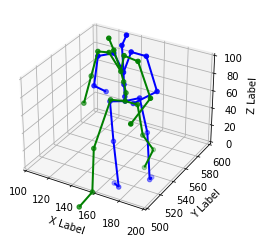

Epoch :  1
Batch : 0, Discriminator loss: 0.34039658308029175, Generator loss : 443.8311475326942
Batch : 10, Discriminator loss: 0.3413698077201843, Generator loss : 415.1246800119019
Batch : 20, Discriminator loss: 0.35610273480415344, Generator loss : 320.7809940297176
Epoch 1 complete, Train cumulated Discriminator loss : 7.973019599914551, Train cumulated Generator loss : 9789.912031770782
Test Discriminator loss : 0.35416603088378906, Test Generator loss : 377.59172746280547
47 6


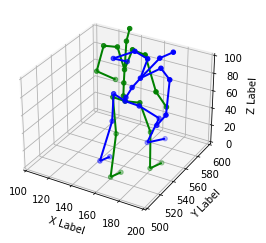

Epoch :  2
Batch : 0, Discriminator loss: 0.36119309067726135, Generator loss : 326.47820532872504
Batch : 10, Discriminator loss: 0.27305784821510315, Generator loss : 463.310450677996
Batch : 20, Discriminator loss: 0.5523083209991455, Generator loss : 396.5343389294759
Epoch 2 complete, Train cumulated Discriminator loss : 8.208442687988281, Train cumulated Generator loss : 8307.163145321856
Test Discriminator loss : 0.5559874773025513, Test Generator loss : 365.7117050829396
72 12


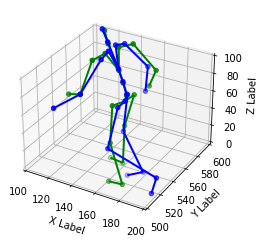

Epoch :  3
Batch : 0, Discriminator loss: 0.4324266314506531, Generator loss : 339.41658710167866
Batch : 10, Discriminator loss: 0.3919699490070343, Generator loss : 264.7502382052098
Batch : 20, Discriminator loss: 0.3146823048591614, Generator loss : 371.5041076913598
Epoch 3 complete, Train cumulated Discriminator loss : 9.724452018737793, Train cumulated Generator loss : 7811.8521775684485
Test Discriminator loss : 0.5926703214645386, Test Generator loss : 348.0626078244449
92 6


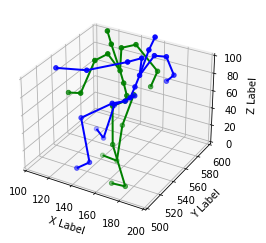

Epoch :  4
Batch : 0, Discriminator loss: 0.5145430564880371, Generator loss : 307.03899864445617
Batch : 10, Discriminator loss: 0.2877544164657593, Generator loss : 336.10537066705405
Batch : 20, Discriminator loss: 0.47465208172798157, Generator loss : 335.9511443640867
Epoch 4 complete, Train cumulated Discriminator loss : 7.877872467041016, Train cumulated Generator loss : 7306.065337530547
Test Discriminator loss : 0.5270993113517761, Test Generator loss : 355.79028963884474
91 11


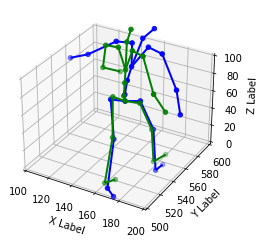

Epoch :  5
Batch : 0, Discriminator loss: 0.5930400490760803, Generator loss : 259.2523661282016
Batch : 10, Discriminator loss: 0.33904924988746643, Generator loss : 403.0976469461941
Batch : 20, Discriminator loss: 0.48434096574783325, Generator loss : 233.62517932392953
Epoch 5 complete, Train cumulated Discriminator loss : 9.001323699951172, Train cumulated Generator loss : 7021.630459806456
Test Discriminator loss : 0.500109076499939, Test Generator loss : 367.6250820792348
24 13


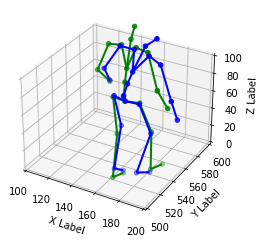

Epoch :  6
Batch : 0, Discriminator loss: 0.37890303134918213, Generator loss : 334.12237919729216
Batch : 10, Discriminator loss: 0.4153531491756439, Generator loss : 351.38043455055464
Batch : 20, Discriminator loss: 0.41764724254608154, Generator loss : 195.68241652896953
Epoch 6 complete, Train cumulated Discriminator loss : 8.9026460647583, Train cumulated Generator loss : 6067.025957213024
Test Discriminator loss : 0.39449647068977356, Test Generator loss : 301.31657481057096
73 1


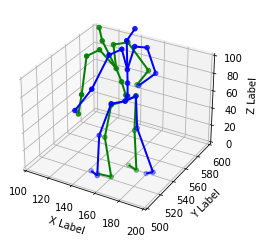

Epoch :  7
Batch : 0, Discriminator loss: 0.33852171897888184, Generator loss : 280.82803749598344
Batch : 10, Discriminator loss: 0.3175744116306305, Generator loss : 327.1031180289005
Batch : 20, Discriminator loss: 0.3334709703922272, Generator loss : 268.08167669739015
Epoch 7 complete, Train cumulated Discriminator loss : 8.004162788391113, Train cumulated Generator loss : 5912.2015669466355
Test Discriminator loss : 0.37691786885261536, Test Generator loss : 399.3419108886458
96 4


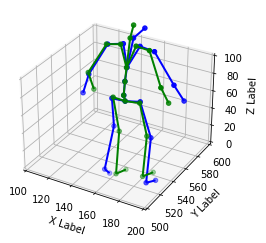

Epoch :  8
Batch : 0, Discriminator loss: 0.3048241436481476, Generator loss : 339.5880772015303
Batch : 10, Discriminator loss: 0.3715510964393616, Generator loss : 355.39868298315866
Batch : 20, Discriminator loss: 0.27862823009490967, Generator loss : 260.80621525642573
Epoch 8 complete, Train cumulated Discriminator loss : 7.540867328643799, Train cumulated Generator loss : 6146.634457178714
Test Discriminator loss : 0.3897419273853302, Test Generator loss : 318.6473573380265
65 8


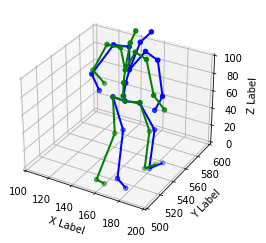

Epoch :  9
Batch : 0, Discriminator loss: 0.2835792899131775, Generator loss : 281.02921455150926
Batch : 10, Discriminator loss: 0.36845773458480835, Generator loss : 244.83291194817636
Batch : 20, Discriminator loss: 0.2734270691871643, Generator loss : 203.0615153723225
Epoch 9 complete, Train cumulated Discriminator loss : 7.231776237487793, Train cumulated Generator loss : 5676.8031770541775
Test Discriminator loss : 0.4461939334869385, Test Generator loss : 313.2769002396233
26 14


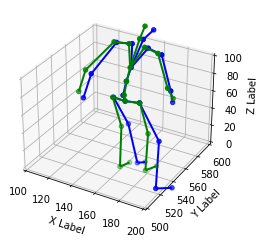

Epoch :  10
Batch : 0, Discriminator loss: 0.284501314163208, Generator loss : 263.86642904150995
Batch : 10, Discriminator loss: 0.3866223096847534, Generator loss : 257.79305893237694
Batch : 20, Discriminator loss: 0.4209083914756775, Generator loss : 234.0853071339708
Epoch 10 complete, Train cumulated Discriminator loss : 6.766743183135986, Train cumulated Generator loss : 5410.668381163341
Test Discriminator loss : 0.4672142565250397, Test Generator loss : 360.6441933731486
26 6


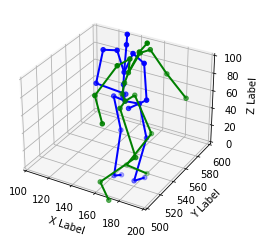

Epoch :  11
Batch : 0, Discriminator loss: 0.44710129499435425, Generator loss : 191.16123479022616
Batch : 10, Discriminator loss: 0.33765068650245667, Generator loss : 287.45084978023704
Batch : 20, Discriminator loss: 0.4093392491340637, Generator loss : 245.98529480705673
Epoch 11 complete, Train cumulated Discriminator loss : 9.090831756591797, Train cumulated Generator loss : 5283.39241853145
Test Discriminator loss : 0.4436233341693878, Test Generator loss : 317.6870581326075
72 0


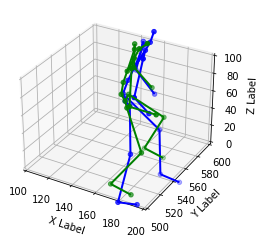

Epoch :  12
Batch : 0, Discriminator loss: 0.3857283294200897, Generator loss : 215.35960648190223
Batch : 10, Discriminator loss: 0.3189351558685303, Generator loss : 290.08023656297235
Batch : 20, Discriminator loss: 0.25814932584762573, Generator loss : 203.7122820600948
Epoch 12 complete, Train cumulated Discriminator loss : 7.314302444458008, Train cumulated Generator loss : 5409.212529824378
Test Discriminator loss : 0.5633589029312134, Test Generator loss : 298.6742592610089
18 1


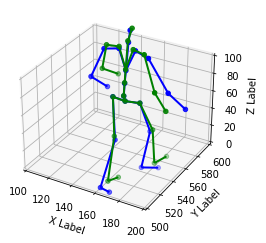

Epoch :  13
Batch : 0, Discriminator loss: 0.3554263114929199, Generator loss : 218.03033507036582
Batch : 10, Discriminator loss: 0.3728736639022827, Generator loss : 236.70009507358048
Batch : 20, Discriminator loss: 0.3593064546585083, Generator loss : 263.6107757251933
Epoch 13 complete, Train cumulated Discriminator loss : 8.708433151245117, Train cumulated Generator loss : 5089.613513968877
Test Discriminator loss : 0.44772449135780334, Test Generator loss : 297.81241976727733
13 14


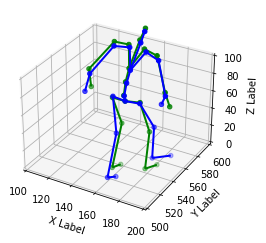

Epoch :  14
Batch : 0, Discriminator loss: 0.29239827394485474, Generator loss : 168.81734665802438
Batch : 10, Discriminator loss: 0.35444194078445435, Generator loss : 212.28138775363036
Batch : 20, Discriminator loss: 0.27481359243392944, Generator loss : 256.36842056992106
Epoch 14 complete, Train cumulated Discriminator loss : 7.677828311920166, Train cumulated Generator loss : 4921.718267954196
Test Discriminator loss : 0.3797314167022705, Test Generator loss : 354.13898527181914
15 2


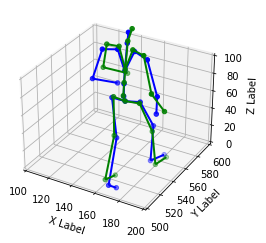

Epoch :  15
Batch : 0, Discriminator loss: 0.3025571405887604, Generator loss : 146.04931418783687
Batch : 10, Discriminator loss: 0.23862528800964355, Generator loss : 250.42491033376916
Batch : 20, Discriminator loss: 0.3929597735404968, Generator loss : 199.02678983684942
Epoch 15 complete, Train cumulated Discriminator loss : 6.737480163574219, Train cumulated Generator loss : 4805.810594314679
Test Discriminator loss : 0.482407808303833, Test Generator loss : 242.87970613193832
79 1


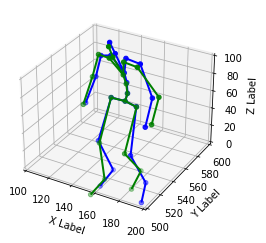

Epoch :  16
Batch : 0, Discriminator loss: 0.371753454208374, Generator loss : 160.30005731090353
Batch : 10, Discriminator loss: 0.3097681999206543, Generator loss : 279.6401467434301
Batch : 20, Discriminator loss: 0.3454948663711548, Generator loss : 185.05177897383817
Epoch 16 complete, Train cumulated Discriminator loss : 7.028693199157715, Train cumulated Generator loss : 4754.691117931037
Test Discriminator loss : 0.49463698267936707, Test Generator loss : 505.8292637987417
95 5


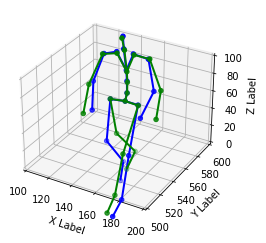

Epoch :  17
Batch : 0, Discriminator loss: 0.40026217699050903, Generator loss : 234.63389805261093
Batch : 10, Discriminator loss: 0.3429420590400696, Generator loss : 278.5497605068012
Batch : 20, Discriminator loss: 0.30870136618614197, Generator loss : 212.01589136868398
Epoch 17 complete, Train cumulated Discriminator loss : 7.767173767089844, Train cumulated Generator loss : 4789.990454510768
Test Discriminator loss : 0.5438128709793091, Test Generator loss : 545.71162845911
1 11


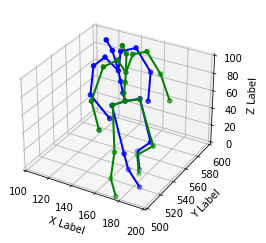

Epoch :  18
Batch : 0, Discriminator loss: 0.25867003202438354, Generator loss : 247.9824092417532
Batch : 10, Discriminator loss: 0.22386591136455536, Generator loss : 238.9875839325511
Batch : 20, Discriminator loss: 0.323340505361557, Generator loss : 227.6708313971571
Epoch 18 complete, Train cumulated Discriminator loss : 6.054821014404297, Train cumulated Generator loss : 4849.563051488896
Test Discriminator loss : 0.3736667037010193, Test Generator loss : 440.310206680017
29 13


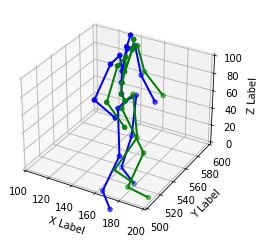

Epoch :  19
Batch : 0, Discriminator loss: 0.39300835132598877, Generator loss : 194.10030822484345
Batch : 10, Discriminator loss: 0.3324221968650818, Generator loss : 196.33349289104953
Batch : 20, Discriminator loss: 0.36831361055374146, Generator loss : 223.6659528060104
Epoch 19 complete, Train cumulated Discriminator loss : 7.5821685791015625, Train cumulated Generator loss : 4662.8063171022495
Test Discriminator loss : 0.36549511551856995, Test Generator loss : 357.56166620195916
60 15


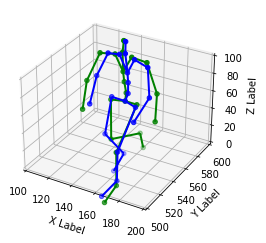

Epoch :  20
Batch : 0, Discriminator loss: 0.36950135231018066, Generator loss : 197.56233125637172
Batch : 10, Discriminator loss: 0.27253568172454834, Generator loss : 250.51459938984655
Batch : 20, Discriminator loss: 0.2854977250099182, Generator loss : 231.5487467564155
Epoch 20 complete, Train cumulated Discriminator loss : 6.200173854827881, Train cumulated Generator loss : 4755.694628810877
Test Discriminator loss : 0.5833115577697754, Test Generator loss : 398.10878265803956
44 2


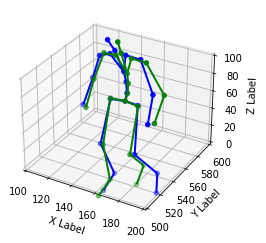

Epoch :  21
Batch : 0, Discriminator loss: 0.3429768681526184, Generator loss : 226.71107781211884
Batch : 10, Discriminator loss: 0.22834202647209167, Generator loss : 274.2703171921184
Batch : 20, Discriminator loss: 0.2727290987968445, Generator loss : 163.6990371043438
Epoch 21 complete, Train cumulated Discriminator loss : 6.768537998199463, Train cumulated Generator loss : 4699.190517229351
Test Discriminator loss : 0.4455961585044861, Test Generator loss : 444.76550790261297
82 0


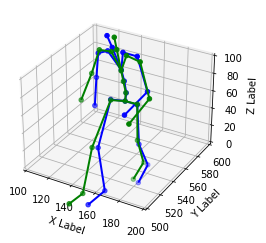

Epoch :  22
Batch : 0, Discriminator loss: 0.2096671760082245, Generator loss : 208.00318527450725
Batch : 10, Discriminator loss: 0.2689513564109802, Generator loss : 197.35794026637078
Batch : 20, Discriminator loss: 0.3083833158016205, Generator loss : 209.88944137243863
Epoch 22 complete, Train cumulated Discriminator loss : 5.973532199859619, Train cumulated Generator loss : 4864.359738511434
Test Discriminator loss : 0.35486775636672974, Test Generator loss : 411.6629883535989
82 3


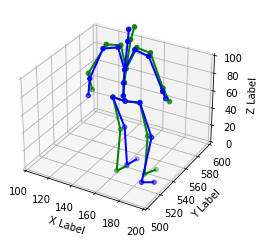

Epoch :  23
Batch : 0, Discriminator loss: 0.3091287612915039, Generator loss : 261.05834961379014
Batch : 10, Discriminator loss: 0.2042430341243744, Generator loss : 212.7163204338189
Batch : 20, Discriminator loss: 0.26022422313690186, Generator loss : 217.45729595868028
Epoch 23 complete, Train cumulated Discriminator loss : 5.821078300476074, Train cumulated Generator loss : 4805.725451735641
Test Discriminator loss : 0.47410842776298523, Test Generator loss : 333.5123727305329
17 1


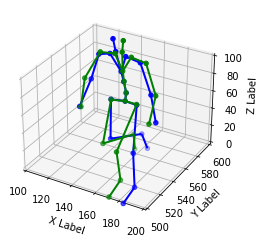

Epoch :  24
Batch : 0, Discriminator loss: 0.29487913846969604, Generator loss : 222.6034045207647
Batch : 10, Discriminator loss: 0.3251129984855652, Generator loss : 207.39780509021918
Batch : 20, Discriminator loss: 0.33963698148727417, Generator loss : 189.6749330891243
Epoch 24 complete, Train cumulated Discriminator loss : 6.104272365570068, Train cumulated Generator loss : 4944.959370534914
Test Discriminator loss : 0.4438340961933136, Test Generator loss : 442.17555829780616
90 11


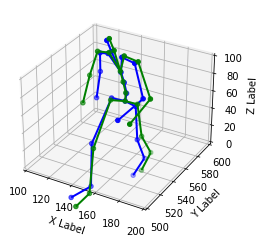

Epoch :  25
Batch : 0, Discriminator loss: 0.325309157371521, Generator loss : 246.2390962383513
Batch : 10, Discriminator loss: 0.4506092667579651, Generator loss : 180.77711755186135
Batch : 20, Discriminator loss: 0.40412136912345886, Generator loss : 194.59807619053154
Epoch 25 complete, Train cumulated Discriminator loss : 6.465458869934082, Train cumulated Generator loss : 4803.2989725683365
Test Discriminator loss : 0.3430572748184204, Test Generator loss : 363.6848696686708
80 3


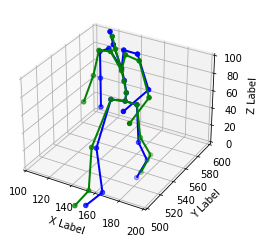

Epoch :  26
Batch : 0, Discriminator loss: 0.4623706340789795, Generator loss : 239.71605092879497
Batch : 10, Discriminator loss: 0.16093596816062927, Generator loss : 232.00758224144758
Batch : 20, Discriminator loss: 0.3157995045185089, Generator loss : 296.43416776946873
Epoch 26 complete, Train cumulated Discriminator loss : 6.444250583648682, Train cumulated Generator loss : 4905.202254189022
Test Discriminator loss : 0.546389102935791, Test Generator loss : 276.90577884806385
25 5


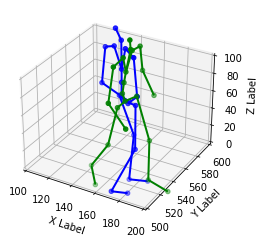

Epoch :  27
Batch : 0, Discriminator loss: 0.3349248766899109, Generator loss : 290.38258366387197
Batch : 10, Discriminator loss: 0.43957802653312683, Generator loss : 210.81895247572157
Batch : 20, Discriminator loss: 0.33808836340904236, Generator loss : 203.4554035656466
Epoch 27 complete, Train cumulated Discriminator loss : 7.219481468200684, Train cumulated Generator loss : 4718.086987921804
Test Discriminator loss : 0.38808807730674744, Test Generator loss : 512.9803110225914
77 6


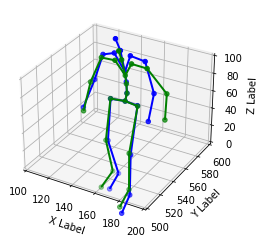

Epoch :  28
Batch : 0, Discriminator loss: 0.33686548471450806, Generator loss : 260.67106714920095
Batch : 10, Discriminator loss: 0.2395629584789276, Generator loss : 208.1386714221998
Batch : 20, Discriminator loss: 0.40702933073043823, Generator loss : 221.8096529094197
Epoch 28 complete, Train cumulated Discriminator loss : 7.020157337188721, Train cumulated Generator loss : 4803.031318506272
Test Discriminator loss : 0.5161455869674683, Test Generator loss : 689.3058669439355
50 2


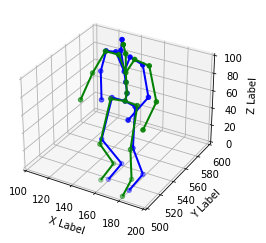

Epoch :  29
Batch : 0, Discriminator loss: 0.29740434885025024, Generator loss : 149.31999493125952
Batch : 10, Discriminator loss: 0.19225692749023438, Generator loss : 264.8231850473024
Batch : 20, Discriminator loss: 0.4916614592075348, Generator loss : 212.11166030382822
Epoch 29 complete, Train cumulated Discriminator loss : 6.584017753601074, Train cumulated Generator loss : 4951.744377708414
Test Discriminator loss : 0.6330980062484741, Test Generator loss : 347.27370148014074
35 6


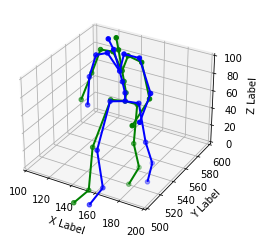

Epoch :  30
Batch : 0, Discriminator loss: 0.5058712959289551, Generator loss : 236.2244094756454
Batch : 10, Discriminator loss: 0.2948897182941437, Generator loss : 238.95996424873036
Batch : 20, Discriminator loss: 0.4493044912815094, Generator loss : 238.29962439282966
Epoch 30 complete, Train cumulated Discriminator loss : 9.05245304107666, Train cumulated Generator loss : 4763.456039003887
Test Discriminator loss : 0.48489007353782654, Test Generator loss : 702.5917536903777
23 4


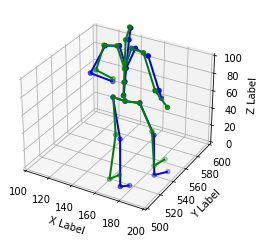

Epoch :  31
Batch : 0, Discriminator loss: 0.4090079665184021, Generator loss : 188.74114071763017
Batch : 10, Discriminator loss: 0.37099751830101013, Generator loss : 273.3238810273065
Batch : 20, Discriminator loss: 0.5912914276123047, Generator loss : 225.6714959609427
Epoch 31 complete, Train cumulated Discriminator loss : 9.372123718261719, Train cumulated Generator loss : 4882.210866115651
Test Discriminator loss : 0.6620261073112488, Test Generator loss : 701.7211545877651
97 5


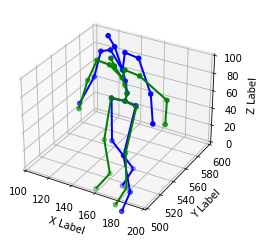

Epoch :  32
Batch : 0, Discriminator loss: 0.457370787858963, Generator loss : 234.88356129884102
Batch : 10, Discriminator loss: 0.4082093834877014, Generator loss : 201.83305648608334
Batch : 20, Discriminator loss: 0.546175479888916, Generator loss : 180.19345405620587
Epoch 32 complete, Train cumulated Discriminator loss : 9.490263938903809, Train cumulated Generator loss : 4573.012976725841
Test Discriminator loss : 0.43753889203071594, Test Generator loss : 641.3062495326858
91 8


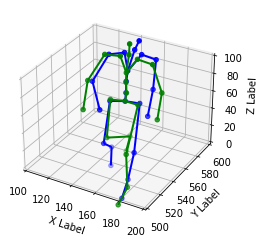

Epoch :  33
Batch : 0, Discriminator loss: 0.4539825916290283, Generator loss : 253.36228892696457
Batch : 10, Discriminator loss: 0.40366020798683167, Generator loss : 182.97257902278537
Batch : 20, Discriminator loss: 0.3530803322792053, Generator loss : 279.31639307755404
Epoch 33 complete, Train cumulated Discriminator loss : 8.609281539916992, Train cumulated Generator loss : 5103.541823560341
Test Discriminator loss : 0.38728171586990356, Test Generator loss : 358.88832816573154
46 7


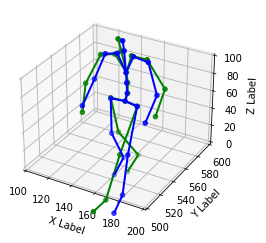

Epoch :  34
Batch : 0, Discriminator loss: 0.34851616621017456, Generator loss : 172.5304141394363
Batch : 10, Discriminator loss: 0.3907187581062317, Generator loss : 239.68903760257749
Batch : 20, Discriminator loss: 0.4482276141643524, Generator loss : 236.04572500901432
Epoch 34 complete, Train cumulated Discriminator loss : 8.59975528717041, Train cumulated Generator loss : 4892.936482724074
Test Discriminator loss : 0.4511539936065674, Test Generator loss : 332.4968205195721
40 12


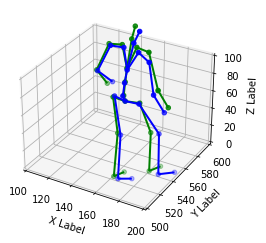

Epoch :  35
Batch : 0, Discriminator loss: 0.3126741647720337, Generator loss : 218.98379315908545
Batch : 10, Discriminator loss: 0.41630053520202637, Generator loss : 182.80205882837515
Batch : 20, Discriminator loss: 0.31438982486724854, Generator loss : 228.30495632571916
Epoch 35 complete, Train cumulated Discriminator loss : 8.396988868713379, Train cumulated Generator loss : 4489.10857127716
Test Discriminator loss : 0.4842841923236847, Test Generator loss : 299.88520041536225
78 8


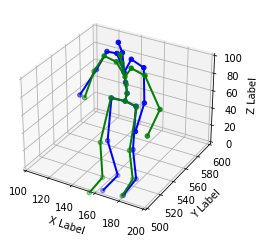

Epoch :  36
Batch : 0, Discriminator loss: 0.41381964087486267, Generator loss : 224.38689814036303
Batch : 10, Discriminator loss: 0.474429190158844, Generator loss : 220.03481521120955
Batch : 20, Discriminator loss: 0.38074830174446106, Generator loss : 143.36149044519692
Epoch 36 complete, Train cumulated Discriminator loss : 7.986612796783447, Train cumulated Generator loss : 4426.659402432611
Test Discriminator loss : 0.5048784017562866, Test Generator loss : 367.59717756974493
51 4


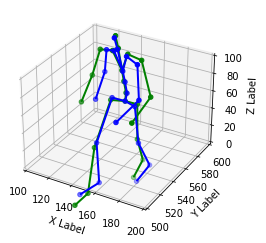

Epoch :  37
Batch : 0, Discriminator loss: 0.3583260178565979, Generator loss : 182.92696030805254
Batch : 10, Discriminator loss: 0.4373003840446472, Generator loss : 201.37353763983484
Batch : 20, Discriminator loss: 0.36919915676116943, Generator loss : 188.95783790346465
Epoch 37 complete, Train cumulated Discriminator loss : 8.699706077575684, Train cumulated Generator loss : 4267.451979568205
Test Discriminator loss : 0.5227231383323669, Test Generator loss : 329.44750833493674
0 3


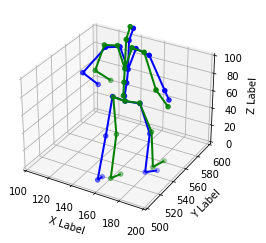

Epoch :  38
Batch : 0, Discriminator loss: 0.42590630054473877, Generator loss : 156.1027138400586
Batch : 10, Discriminator loss: 0.3824485242366791, Generator loss : 133.0846493291697
Batch : 20, Discriminator loss: 0.40019023418426514, Generator loss : 157.14342906775587
Epoch 38 complete, Train cumulated Discriminator loss : 8.577925682067871, Train cumulated Generator loss : 4280.880692208513
Test Discriminator loss : 0.4806469976902008, Test Generator loss : 409.2778451390344
62 9


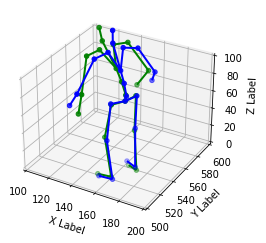

Epoch :  39
Batch : 0, Discriminator loss: 0.3822875916957855, Generator loss : 174.17805336502434
Batch : 10, Discriminator loss: 0.323720782995224, Generator loss : 214.3756446211282
Batch : 20, Discriminator loss: 0.3911288380622864, Generator loss : 177.81441072050242
Epoch 39 complete, Train cumulated Discriminator loss : 8.893178939819336, Train cumulated Generator loss : 4297.387137671312
Test Discriminator loss : 0.48465168476104736, Test Generator loss : 466.7649622517304
49 2


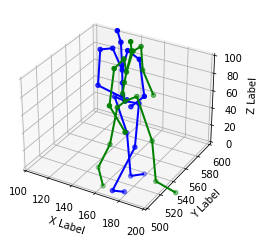

Epoch :  40
Batch : 0, Discriminator loss: 0.3739158809185028, Generator loss : 216.3803104896136
Batch : 10, Discriminator loss: 0.45710015296936035, Generator loss : 161.98563138862923
Batch : 20, Discriminator loss: 0.371936559677124, Generator loss : 208.23710347910716
Epoch 40 complete, Train cumulated Discriminator loss : 8.452733993530273, Train cumulated Generator loss : 4092.9185266456757
Test Discriminator loss : 0.614617645740509, Test Generator loss : 363.57048868905014
7 5


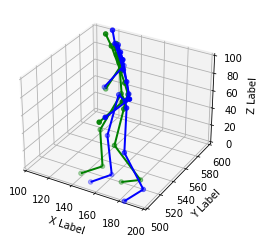

Epoch :  41
Batch : 0, Discriminator loss: 0.39072364568710327, Generator loss : 172.13808088774877
Batch : 10, Discriminator loss: 0.3741929829120636, Generator loss : 178.5621804647084
Batch : 20, Discriminator loss: 0.4353766441345215, Generator loss : 148.51680170546035
Epoch 41 complete, Train cumulated Discriminator loss : 8.473967552185059, Train cumulated Generator loss : 4170.750966085174
Test Discriminator loss : 0.5761387944221497, Test Generator loss : 568.1355447837576
88 8


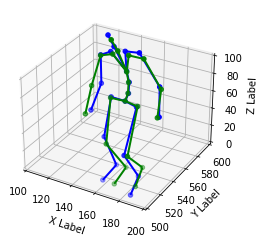

Epoch :  42
Batch : 0, Discriminator loss: 0.3944985866546631, Generator loss : 171.7366265566036
Batch : 10, Discriminator loss: 0.3933635950088501, Generator loss : 231.25269087996838
Batch : 20, Discriminator loss: 0.49120497703552246, Generator loss : 176.3987149393432
Epoch 42 complete, Train cumulated Discriminator loss : 9.281575202941895, Train cumulated Generator loss : 4046.238822620679
Test Discriminator loss : 0.5085715651512146, Test Generator loss : 414.75288914698496
1 15


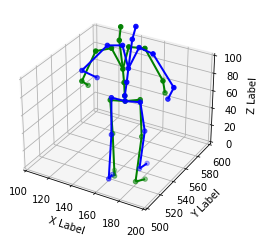

Epoch :  43
Batch : 0, Discriminator loss: 0.4922237694263458, Generator loss : 153.17071684532917
Batch : 10, Discriminator loss: 0.378895103931427, Generator loss : 180.1552733867985
Batch : 20, Discriminator loss: 0.4611033797264099, Generator loss : 135.8446095414202
Epoch 43 complete, Train cumulated Discriminator loss : 8.946609497070312, Train cumulated Generator loss : 4075.85318089293
Test Discriminator loss : 0.4894583225250244, Test Generator loss : 643.7259893846239
9 11


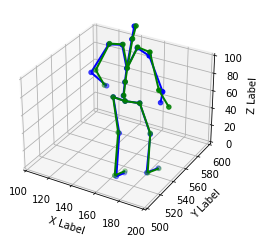

Epoch :  44
Batch : 0, Discriminator loss: 0.38844114542007446, Generator loss : 179.11024065586105
Batch : 10, Discriminator loss: 0.42392200231552124, Generator loss : 185.66476466226928
Batch : 20, Discriminator loss: 0.404459148645401, Generator loss : 154.35699348866606
Epoch 44 complete, Train cumulated Discriminator loss : 9.253825187683105, Train cumulated Generator loss : 4005.3631464806967
Test Discriminator loss : 0.46711093187332153, Test Generator loss : 397.2171774645358
44 12


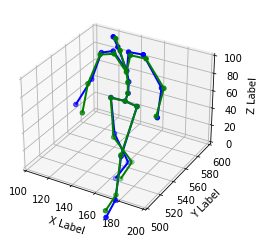

Epoch :  45


KeyboardInterrupt: 

In [12]:
t = time.localtime()
log_dir = './runs/AE/AddedHeight/min_{}_decay_{}_freq_{}_time_{}/'.format(0.0001,0.97,0.15, time.strftime("%H_%M_%S", t))
writer = SummaryWriter(log_dir)


D_per_ep_train = torch.zeros(epochs,requires_grad=False)
G_per_ep_train = torch.zeros(epochs,requires_grad=False)

G_loss_adv_train  = torch.zeros(epochs,requires_grad=False)
G_loss_ee_train   = torch.zeros(epochs,requires_grad=False)
G_loss_velo_train = torch.zeros(epochs,requires_grad=False)
G_loss_glob_train = torch.zeros(epochs,requires_grad=False)

D_per_ep_test = torch.zeros(epochs,requires_grad=False)
G_per_ep_test = torch.zeros(epochs,requires_grad=False)

G_loss_adv_test  = torch.zeros(epochs,requires_grad=False)
G_loss_ee_test   = torch.zeros(epochs,requires_grad=False)
G_loss_velo_test = torch.zeros(epochs,requires_grad=False)
G_loss_glob_test = torch.zeros(epochs,requires_grad=False)

D_cumul = 0
G_cumul = 0

G_loss_adv_cumul  = 0
G_loss_ee_cumul   = 0
G_loss_velo_cumul = 0
G_loss_glob_cumul = 0

for ep in range(epochs):
    print('Epoch : ', ep)
    for i, motion in enumerate(train_Motion_Data):
        
        # reshape motion to [batch_size, window_size, n_joints*channel_size]
        motion = motion.reshape(motion.shape[0], motion.shape[-2], motion.shape[-1]).float()
        curr_batch_size = motion.shape[0]
        offsets = skdata.offsets.reshape(1, 1, skdata.offsets.shape[0], skdata.offsets.shape[1])
        offsets = offsets.repeat(curr_batch_size, options['window_size'], 1, 1)

        #----------------------------------------------------
        # GENERATE AUTO ENCODED POSE
        #----------------------------------------------------

        # first get the offsets from the static encoder 
        # deep_offsets = static_encoder(torch.tensor(anim.offsets[np.newaxis, :,:]).float())
        deep_offsets = static_encoder(skdata.offsets.reshape(1, skdata.offsets.shape[0], -1))
        latent, res = auto_encoder(motion, deep_offsets)
        
        # denormalize data to get correct forward kinematics 
        if isNormalize is True:
            res = dataset.denormalize(res)
            motion = dataset.denormalize(motion)
    
        # transform res shape from [batch_size, (rotations+glob_pos+1), window_size]
        # to [batch_size, window_size, n_joints,4]
        res = res.permute(0,2,1).reshape(curr_batch_size, options['window_size'], -1, options['channel_base'])
        motion = motion.permute(0,2,1).reshape(curr_batch_size, options['window_size'], -1, options['channel_base'])
        
        res_rotation = res[:,:,:-1,:]
        motion_rotation = motion[:,:,:-1,:]
        res_glob_velo  = res[:,:,-1:,:-1]
        motion_glob_velo  = motion[:,:,-1:,:-1]
        
        # the current output rotation is not necessarily a normalized quaternion
        res_rotation = torch.nn.functional.normalize(res_rotation, dim=3)
        
        res_glob = res_rotation[:,:,0,:].reshape(curr_batch_size, options['window_size'], -1)
        motion_glob = motion_rotation[:,:,0,:].reshape(curr_batch_size, options['window_size'], -1)

        # apply fk on generated pos, this will be the 'fake' data in the discriminator
        _, real_pos = lafan_utils.quat_fk(motion_rotation, offsets, skdata.parents)
        _, fake_pos = lafan_utils.quat_fk(res_rotation, offsets, skdata.parents)
        
        # local positions used for ee loss by setting the first rotation as an 
        # identity quaternion
        motion_rotation_local = torch.clone(motion_rotation)
        res_rotation_local = torch.clone(res_rotation)

        motion_rotation_local[:,:,0,:] = torch.tensor([1,0,0,0]).float() 
        res_rotation_local[:,:,0,:] = torch.tensor([1,0,0,0]).float() 
        _, real_pos_local = lafan_utils.quat_fk(motion_rotation_local, offsets, skdata.parents)
        _, fake_pos_local = lafan_utils.quat_fk(res_rotation_local, offsets, skdata.parents)

        # the GAN update code is mostly taken from :
        #https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html#loss-functions-and-optimizers
        

        # UPDATE DISCRIMINATOR :
        # first do real data batch then fake data
        
        # start adverserial training after a set number of epochs
        if ep >= discrim_epoch:
            loss_real, loss_fake, loss_discrim = discriminator.D_loss(real_pos, fake_pos, False)
            discrim_optimizer.step()
        
        # UPDATE GENERATOR NETWORK
        auto_encoder.zero_grad()
        static_encoder.zero_grad()
        
        loss_adv = 0
        if ep >= discrim_epoch:
            # use real labels to maximize log(D(G(x))) instead of log(1-D(G(x)))
            label = torch.full((curr_batch_size,), real_label, dtype=torch.float, device=device)
            label.fill_(real_label)
            # use updated discriminator
            output = discriminator(fake_pos.float()).view(-1)
            # Calculate the generator's loss and gradients
            loss_adv = criterion_gan(output,label)
            
        loss_glob = criterion_glob(res_glob, motion_glob)
        # Get the loss that tries to match the total velocity of every corresponding chain        
        real_vel, fake_vel = lafan_utils.get_batch_velo(real_pos, fake_pos, skdata.frametime)
        # loss_chain_velo = calc_chain_velo_loss(real_vel, fake_vel, chain_indices, 
        #                                        criterion_velo, normalize_velo = False)
        loss_chain_velo = criterion_velo(res_glob_velo/skdata.height, motion_glob_velo/skdata.height)
        loss_ee = calc_ee_loss(real_vel, real_pos_local, fake_vel, fake_pos_local,
                               criterion_ee, skdata, skdata)
        

        # combine all the losses together
        loss_gen =  loss_adv*mult_adv + loss_ee*mult_ee + \
        loss_glob*mult_glob + loss_chain_velo*mult_chain_velo
        
        # update gradient
        loss_gen.backward()
        gen_optimizer.step()
        
        # record losses 
        D_cumul += loss_discrim
        G_cumul += loss_gen
        
        G_loss_adv_cumul += loss_adv
        G_loss_ee_cumul  += loss_ee
        G_loss_velo_cumul+= loss_chain_velo
        G_loss_glob_cumul+= loss_glob

        if(i % 10 == 0):
            print("Batch : {}, Discriminator loss: {}, Generator loss : {}".format(i, loss_discrim, loss_gen))
    
    scheduler.step()

    N = len(dataset)
    D_per_ep_train[ep]  =D_cumul/N 
    G_per_ep_train[ep]  =G_cumul/N
    
    G_loss_adv_train[ep]  =G_loss_adv_cumul/N
    G_loss_ee_train[ep]   =G_loss_ee_cumul/N
    G_loss_velo_train[ep] =G_loss_velo_cumul/N
    G_loss_glob_train[ep] =G_loss_glob_cumul/N

    writer.add_scalar('Train/D_loss', D_cumul/N, ep)
    writer.add_scalar('Train/G_loss', G_cumul/N, ep)
    writer.add_scalar('Train/adv_loss', G_loss_adv_cumul/N *mult_adv , ep)
    writer.add_scalar('Train/ee_loss',  G_loss_ee_cumul/N  *mult_ee, ep)
    writer.add_scalar('Train/velo_loss',G_loss_velo_cumul/N*mult_chain_velo, ep)
    writer.add_scalar('Train/glob_loss',G_loss_glob_cumul/N*mult_glob, ep)
    
    writer.add_scalar('Hyperparameter/learning_rate', scheduler.get_last_lr()[0], ep)

    print("Epoch {} complete, Train cumulated Discriminator loss : {}, Train cumulated Generator loss : {}".format(ep, D_cumul, G_cumul) )
    
    D_cumul = 0
    G_cumul = 0
    
    G_loss_adv_cumul  = 0
    G_loss_ee_cumul   = 0
    G_loss_velo_cumul = 0
    G_loss_glob_cumul = 0
    
    #----------------------------------------------------------------------
    # TEST
    #----------------------------------------------------------------------
    with torch.no_grad():
        
        # TEST ON A RANDOM FRAME
        rand_index = np.random.randint(700,800, 100)
        curr_batch_size=100
        test_data = test_dataset[rand_index].float()
        
        motion = test_data        
        offsets = skdata.offsets.reshape(1, 1, skdata.offsets.shape[0], skdata.offsets.shape[1])
        offsets = offsets.repeat(curr_batch_size, options['window_size'], 1, 1)
    
        # first get the offsets from the static encoder 
        # deep_offsets = static_encoder(torch.tensor(anim.offsets[np.newaxis, :,:]).float())
        deep_offsets = static_encoder(skdata.offsets.reshape(1, skdata.offsets.shape[0], -1))
        latent, res = auto_encoder(motion, deep_offsets)

        # denormalize data to get correct forward kinematics 
        if isNormalize is True:
            res = test_dataset.denormalize(res)
            motion = test_dataset.denormalize(test_data)
            
        res = res.permute(0,2,1).reshape(len(rand_index),options['window_size'],-1,4)
        motion = motion.permute(0,2,1).reshape(len(rand_index),options['window_size'],-1,4)

        # res has the shape [batch_size, (rotations+glob_pos+1)]
        res_rotation = res[:,:,:-1,:]
        motion_rotation = motion[:,:,:-1,:]
        res_glob_velo  = res[:,:,-1:,:-1]
        motion_glob_velo  = motion[:,:,-1:,:-1]

        # the current output rotation is not necessarily a normalized quaternion
        res_rotation = torch.nn.functional.normalize(res_rotation, dim=3)

        res_glob = res_rotation[:,:,0,:].reshape(curr_batch_size,options['window_size'],-1)
        motion_glob = motion_rotation[:,:,0,:].reshape(curr_batch_size,options['window_size'],-1)
        
        # apply fk on generated pos, this will be the 'fake' data in the discriminator
        _, real_pos = lafan_utils.quat_fk(motion_rotation, offsets, skdata.parents)
        _, fake_pos = lafan_utils.quat_fk(res_rotation, offsets, skdata.parents)
        
        # get a second set of positions used for ee loss:
        motion_rotation_local = torch.clone(motion_rotation)
        res_rotation_local = torch.clone(res_rotation)

        motion_rotation_local[:,:,0,:] = torch.tensor([1,0,0,0]).float() 
        res_rotation_local[:,:,0,:] = torch.tensor([1,0,0,0]).float() 
        _, real_pos_local = lafan_utils.quat_fk(motion_rotation_local, offsets, skdata.parents)
        _, fake_pos_local = lafan_utils.quat_fk(res_rotation_local, offsets, skdata.parents)

        
        #-----------------
        # GET DISCRIM LOSS
        #-----------------    
        loss_real, loss_fake, loss_discrim = discriminator.D_loss(real_pos, fake_pos, True)
                
        #-----------------
        # GET GEN LOSS
        #-----------------
        # use real labels to maximize log(D(G(x))) instead of log(1-D(G(x)))
        label = torch.full((curr_batch_size,), real_label, dtype=torch.float, device=device)
        label.fill_(real_label)
        # use updated discriminator
        output = discriminator(fake_pos.float()).view(-1)

        # Calculate the generator's loss and gradients
        loss_adv = criterion_gan(output,label)
        loss_glob = criterion_glob(res_glob, motion_glob)

        real_vel, fake_vel = lafan_utils.get_batch_velo(real_pos, fake_pos, skdata.frametime)
        # loss_chain_velo = calc_chain_velo_loss(real_vel, fake_vel, chain_indices, 
        #                                        criterion_velo, normalize_velo = False)
        loss_chain_velo = criterion_velo(res_glob_velo/skdata.height, motion_glob_velo/skdata.height)
        loss_ee = calc_ee_loss(real_vel, real_pos_local, fake_vel, fake_pos_local, 
                               criterion_ee, skdata, skdata)
        
        # combine all the losses together
        loss_gen =  loss_adv*mult_adv + loss_ee*mult_ee + \
        loss_glob*mult_glob + loss_chain_velo*mult_chain_velo
        
        
        D_per_ep_test[ep] = loss_discrim
        G_per_ep_test[ep] = loss_gen
        
        G_loss_adv_test[ep] = loss_adv
        G_loss_ee_test[ep] = loss_ee
        G_loss_velo_test[ep] = loss_chain_velo
        G_loss_glob_test[ep] = loss_glob

        N = 100
        writer.add_scalar('Test/D_loss', loss_discrim/N, ep)
        writer.add_scalar('Test/G_loss', loss_gen/N, ep)
        writer.add_scalar('Test/adv_loss', loss_adv/N       *mult_adv , ep)
        writer.add_scalar('Test/ee_loss',  loss_ee/N        *mult_ee , ep)
        writer.add_scalar('Test/velo_loss',loss_chain_velo/N*mult_chain_velo, ep)
        writer.add_scalar('Test/glob_loss',loss_glob/N      *mult_glob, ep)
        
        # print one
        batch_ind = np.random.randint(0,len(rand_index))
        frame_ind = np.random.randint(0,options['window_size'])

        print("Test Discriminator loss : {}, Test Generator loss : {}".format(loss_discrim, loss_gen) )
        print(batch_ind, frame_ind)
        
        two_skeleton_plot(fake_pos[batch_ind,frame_ind,:,:].cpu().detach(),
                          real_pos[batch_ind,frame_ind,:,:].cpu().detach(),
                          skdata.edges, skdata.edges,
                          'b','g', limits=limits)

writer.close()

In [ ]:
def calc_ee_loss(real_vel, real_pos, fake_vel, fake_pos, criterion_ee, skdata_real : SkeletonInfo, skdata_fake : SkeletonInfo):
    """
    Calculate the end effector loss using the fake velocity and position (local or global)
    """
    # [batch, frame, n_end_effector, 6]
    ee_false = skdata_fake.ee_id
    ee_real = skdata_real.ee_id

    print(fake_pos[:,:,0:1,:].shape)
    fake_pos_loc = fake_pos - fake_pos[:,:,0:1,:]
    real_pos_loc = real_pos - real_pos[:,:,0:1,:]

    fake_ee = torch.cat((fake_vel[:,:,ee_false[ee_false!=0],:], fake_pos_loc[:,:,ee_false[ee_false!=0],:]), dim=2)
    real_ee = torch.cat((real_vel[:,:,ee_real[ee_real!=0],:], real_pos_loc[:,:,ee_real[ee_real!=0],:]), dim=2)

    real_length = skdata_real.ee_length.reshape(1,1,skdata_real.ee_length.shape[0],1)
    fake_length = skdata_fake.ee_length.reshape(1,1,skdata_fake.ee_length.shape[0],1)

    print(torch.repeat_interleave(real_length,2, dim=2))
    real_length = torch.repeat_interleave(real_length,2, dim=2)
    fake_length = torch.repeat_interleave(fake_length,2, dim=2)

    # loss_ee_velo = criterion_ee(fake_joint_vel[:,:,ee_id,:], real_joint_vel[:,:,ee_id,:])
    loss_ee_velo = criterion_ee(fake_ee/fake_length, real_ee/real_length)
    loss_ee_velo /= len(skdata_real.ee_id)

    return loss_ee_velo

loss_ee = calc_ee_loss(real_vel, real_pos_local, fake_vel, fake_pos_local, 
                               criterion_ee, skdata, skdata)
        

In [22]:
# real_pos_local[0,0,:] - real_pos_local[0,0,0,:]
print(skdata.ee_id)

tensor([ 0,  4,  8, 11, 13, 17, 21])


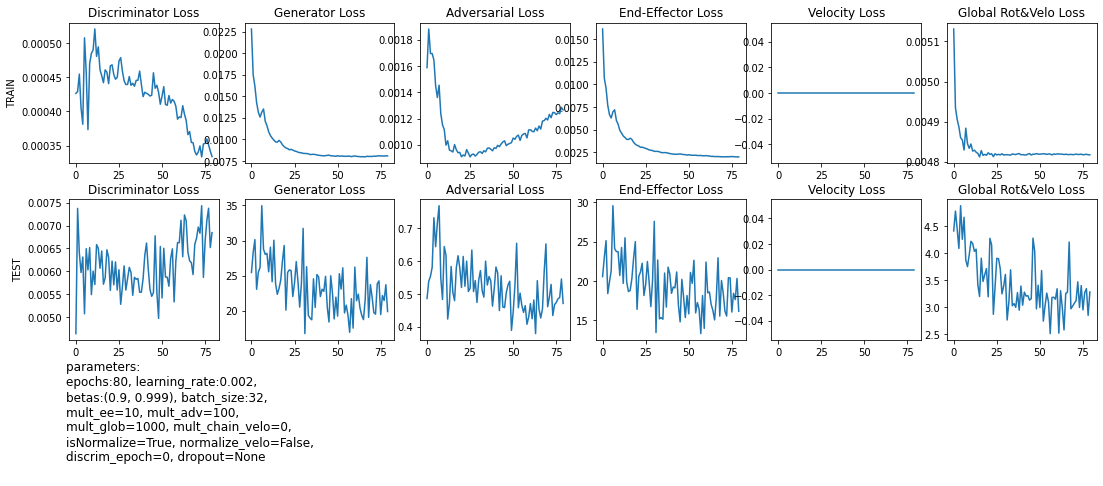

In [28]:
N = len(dataset)


text =  """
        parameters: 
        epochs:{}, learning_rate:{},
        betas:{}, batch_size:{},  
        mult_ee={}, mult_adv={}, 
        mult_glob={}, mult_chain_velo={},
        isNormalize={}, normalize_velo={},
        discrim_epoch={}, dropout={}
        """.format(epochs,learning_rate, betas, batch_size, mult_ee, mult_adv, mult_glob, mult_chain_velo,
                  isNormalize, normalize_velo, discrim_epoch, dropout)

fig, axs = plt.subplots(2,6, figsize=(15,5))
fig.tight_layout(h_pad =1.5,w_pad=-0.5)

axs[0,0].set_ylabel('TRAIN')
axs[0,0].plot(D_per_ep_train.cpu().detach()/i)
axs[0,0].set_title('Discriminator Loss')

axs[0,1].plot(G_per_ep_train.cpu().detach()/N)
axs[0,1].set_title('Generator Loss')

axs[0,2].plot(G_loss_adv_train.cpu().detach()*mult_adv/N)
axs[0,2].set_title('Adversarial Loss')

axs[0,3].plot(G_loss_ee_train.cpu().detach()*mult_ee/N)
axs[0,3].set_title('End-Effector Loss')

axs[0,4].plot(G_loss_velo_train.cpu().detach()*mult_chain_velo/N)
axs[0,4].set_title('Velocity Loss')

axs[0,5].plot(G_loss_glob_train.cpu().detach()*mult_glob/N)
axs[0,5].set_title('Global Rot&Velo Loss')

axs[1,0].set_ylabel('TEST')
axs[1,0].plot(D_per_ep_test.cpu().detach()/len(rand_index))
axs[1,0].set_title('Discriminator Loss')

axs[1,1].plot(G_per_ep_test.cpu().detach()/len(rand_index))
axs[1,1].set_title('Generator Loss')

axs[1,2].plot(G_loss_adv_test.cpu().detach()*mult_adv/len(rand_index))
axs[1,2].set_title('Adversarial Loss')

axs[1,3].plot(G_loss_ee_test.cpu().detach()*mult_ee/len(rand_index))
axs[1,3].set_title('End-Effector Loss')

axs[1,4].plot(G_loss_velo_test.cpu().detach()*mult_chain_velo/len(rand_index))
axs[1,4].set_title('Velocity Loss')

axs[1,5].plot(G_loss_glob_test.cpu().detach()*mult_glob/len(rand_index))
axs[1,5].set_title('Global Rot&Velo Loss')

plt.figtext(0., -0.3, text, ha="left", fontsize=12)

plt.savefig('C:\\Users\\nicol\\Work\\Master\\dissertation\\Results\\AutoEncoder\\LaFan_Train_14_fixed_rotation_same_val.png', bbox_inches="tight",transparent=False)

plt.show()

In [14]:

_, global_fake_pos = lafan_utils.get_global_position_from_velocity(torch.tensor([0,0,0]), 
                                                                   res_glob_velo[0], skdata.frametime,
                                                                   fake_pos[0])
_, global_real_pos = lafan_utils.get_global_position_from_velocity(torch.tensor([0,0,0]), 
                                                                   motion_glob_velo[0], skdata.frametime, 
                                                                   real_pos[0])

In [3]:

from IPython.display import HTML
# from matplotlib import rc

In [8]:
global_real_pos = np.load('real_pos.npy')
global_fake_pos = np.load('fake_pos.npy')
global_real_pos = torch.tensor(global_real_pos)
global_fake_pos = torch.tensor(global_fake_pos)
%matplotlib qt
anim = motion_animation(global_real_pos.cpu().detach(), global_fake_pos.cpu().detach(), skdata.edges, skdata.edges, limits)
HTML(anim.to_jshtml())
plt.show()
%matploplib inline

c:\users\nicol\work\master\dissertation\ml-agents\ml-agents\mlagents\plugins\bvh_utils\visualize.py:104: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = p3.Axes3D(fig)


ValueError: could not broadcast input array from shape (3,3) into shape (3,)

In [20]:
np.save('real_pos.npy', real_pos.cpu().detach())
np.save('fake_pos.npy', fake_pos.cpu().detach())